In definitiva, l'approccio che hai descritto è una strategia valida per la riduzione del numero di classi, ma richiede attenzione nella fase di clustering e nell'interpretazione dei risultati per assicurarsi che i generi musicali siano raggruppati in modo significativo dal punto di vista musicale.

- Dividi il dataset in subset, uno per ogni classe di genere musicale. Ad esempio, se hai 20 classi di generi musicali, avrai 20 subset.
- Per ciascun subset, esegui K-Means con k=1 per trovare il centroide rappresentativo.
- Dopo aver ottenuto i centroidi per ogni classe, confronta la similarità tra i centroidi utilizzando una metrica di similarità appropriata, ad esempio la distanza euclidea.
- Unisci le classi che hanno centroidi simili sopra una soglia di similarità definita da te. Ad esempio, se due centroidi sono più vicini di una certa soglia, potresti considerarli come appartenenti allo stesso gruppo.
- Aggiorna le etichette delle classi di genere musicali basate sulle fusioni effettuate.
- Valuta l'efficacia della nuova configurazione di classificazione utilizzando metriche di valutazione appropriate.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

from sktime.transformations.compose import FitInTransform
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sktime.transformations.panel.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder

In [2]:
import pyts
from pyts import classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, RepeatedStratifiedKFold

from sklearn.metrics import make_scorer, accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve
from scikitplot.metrics import plot_roc
from sklearn.metrics import confusion_matrix

from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize

In [3]:
# Get the centroids
def getNearestTS(data, centroids):
    centroids = np.squeeze(centroids)

    # Function to calculate DTW distance between two time series
    def dtw_distance(ts1, ts2):
        distance, _ = fastdtw(ts1, ts2)
        return distance

    # Calculate the distance between each centroid and all time series data points
    distances = cdist(centroids, data, metric=dtw_distance)

    # Find the nearest time series for each centroid
    nearest_indices = np.argmin(distances, axis=1)

    # Retrieve the nearest time series for each centroid
    #nearest_time_series = [x_train_dft[i] for i in nearest_indices]

    # Print the results
    for i, centroid in enumerate(centroids):
        print (f"Centroid {i}: Nearest Time Series Index = {nearest_indices[i]}")

In [4]:
def load_npy(filename):
    return np.load(filename)

## verifica quali sono le due classi più distanti

In [5]:
# reload 
X_y_ids = load_npy(r'C:\Users\HUAWEI\Desktop\DM2\project NEW\output_data\X_y_ids.npz') 
X, y, ids = X_y_ids['arr_0'], X_y_ids['arr_1'], X_y_ids['arr_2']

In [6]:
#per trasformare in dataframe

df = pd.DataFrame(np.squeeze(X))
df["genre"] = y

In [7]:
df['genre'].value_counts()

genre
happy                500
emo                  500
new-age              500
minimal-techno       500
folk                 500
j-idol               500
sleep                500
kids                 500
songwriter           500
sertanejo            500
goth                 500
piano                500
opera                500
synth-pop            500
honky-tonk           500
mpb                  500
progressive-house    500
heavy-metal          500
world-music          500
salsa                500
Name: count, dtype: int64

In [8]:
# Assegna la variabile target
y = df.iloc[:, -1].values

# Assegna il resto dei valori a X escludendo l'ultima colonna
X = df.iloc[:, :-1].values
X.shape, y.shape


((10000, 1280), (10000,))

In [9]:
df['genre'].unique()

array(['happy', 'emo', 'world-music', 'heavy-metal', 'progressive-house',
       'mpb', 'honky-tonk', 'synth-pop', 'opera', 'piano', 'goth',
       'sertanejo', 'songwriter', 'kids', 'sleep', 'j-idol', 'folk',
       'minimal-techno', 'new-age', 'salsa'], dtype=object)

In [71]:
# Inizializza e addestra il LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Crea un dizionario che mappa le classi originali ai loro valori codificati
classi_originali_vs_codificate = dict(zip(y, y_encoded))

# Ora puoi accedere al valore codificato di una classe originale
classe_originale = 'kids'
valore_codificato = classi_originali_vs_codificate[classe_originale]
print(f"Il valore codificato per '{classe_originale}' è: {valore_codificato}")


Il valore codificato per 'kids' è: 7


In [72]:
X.shape, y_encoded.shape

((10000, 1280), (10000,))

In [73]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset
import numpy as np
from tslearn.metrics import dtw


# Definiamo il numero di classi di genere musicale
num_classi = 20

# Inizializziamo un dizionario per memorizzare i centroidi per ciascuna classe di genere musicale
centroidi_per_classe = {}

# Convertiamo le serie temporali in un formato compatibile con tslearn
#X = to_time_series_dataset(X)

# Dividiamo il dataset in subset per ogni classe di genere musicale
for classe in range(num_classi):
    subset_X = X[y_encoded == classe]  # Seleziona solo le serie temporali appartenenti alla classe corrente
    kmeans = TimeSeriesKMeans(n_clusters=1, metric= "euclidean", verbose=0, random_state=42).fit(subset_X)  # Esegui TimeSeriesKMeans con k=1
    centroidi_per_classe[classe] = kmeans.cluster_centers_[0]  # Salva il centroide per la classe corrente

# Inizializziamo una matrice di similarità per memorizzare la similarità tra i centroidi
similarità = np.zeros((num_classi, num_classi))

# Calcoliamo la similarità tra tutti i centroidi utilizzando la distanza euclidea
for i in range(num_classi):
    for j in range(num_classi):
        # Calcoliamo la distanza euclidea tra i centroidi delle classi i e j
        distanza_euclidea = np.linalg.norm(centroidi_per_classe[i] - centroidi_per_classe[j])
        # Memorizziamo la distanza euclidea nella matrice di similarità
        similarità[i][j] = distanza_euclidea


In [74]:
# Troviamo le classi con la massima distanza tra i centroidi
max_distance = np.max(similarità)  # Trova la massima distanza nella matrice di similarità
max_distance_index = np.unravel_index(np.argmax(similarità, axis=None), similarità.shape)  # Trova l'indice della massima distanza

# Ottieni gli indici delle classi con la massima distanza
classe1_index = max_distance_index[0]
classe2_index = max_distance_index[1]

# Stampa le classi con la massima distanza
print("Classi con la massima distanza tra i centroidi:")
print("Classe", classe1_index, "e Classe", classe2_index)


Classi con la massima distanza tra i centroidi:
Classe 3 e Classe 12


In [78]:
# # Ora puoi accedere al valore codificato di una classe originale
# classe_originale = 'emo'
# valore_codificato = classi_originali_vs_codificate[classe_originale]
# print(f"Il valore codificato per '{classe_originale}' è: {valore_codificato}")


a = ['happy', 'emo', 'world-music', 'heavy-metal', 'progressive-house',
       'mpb', 'honky-tonk', 'synth-pop', 'opera', 'piano', 'goth',
       'sertanejo', 'songwriter', 'kids', 'sleep', 'j-idol', 'folk',
       'minimal-techno', 'new-age', 'salsa']


for e in a:
    valore_codificato = classi_originali_vs_codificate[e]
    print(f"Il valore codificato per '{e}' è: {valore_codificato}")



Il valore codificato per 'happy' è: 3
Il valore codificato per 'emo' è: 0
Il valore codificato per 'world-music' è: 19
Il valore codificato per 'heavy-metal' è: 4
Il valore codificato per 'progressive-house' è: 13
Il valore codificato per 'mpb' è: 9
Il valore codificato per 'honky-tonk' è: 5
Il valore codificato per 'synth-pop' è: 18
Il valore codificato per 'opera' è: 11
Il valore codificato per 'piano' è: 12
Il valore codificato per 'goth' è: 2
Il valore codificato per 'sertanejo' è: 15
Il valore codificato per 'songwriter' è: 17
Il valore codificato per 'kids' è: 7
Il valore codificato per 'sleep' è: 16
Il valore codificato per 'j-idol' è: 6
Il valore codificato per 'folk' è: 1
Il valore codificato per 'minimal-techno' è: 8
Il valore codificato per 'new-age' è: 10
Il valore codificato per 'salsa' è: 14


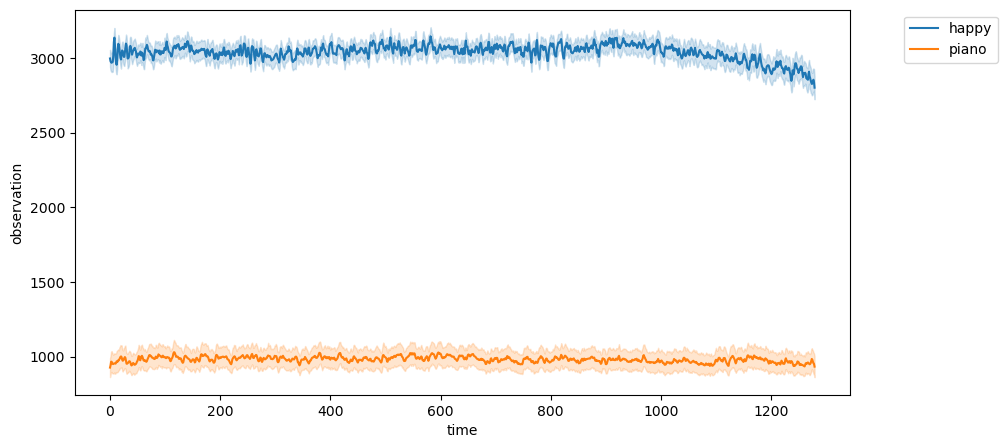

In [81]:
a = ['happy','piano']


plt.figure(figsize=(10, 5))  # Imposta larghezza a 10 pollici e altezza a 6 pollici
#filtro solo per alcuni generi
df_filtered = df[df['genre'].isin(a)] 

df_melt = df_filtered.melt(value_name="observation", var_name="time", id_vars="genre")
#cosi posso osservare ts per x generi scelti dalla target

sns.lineplot(df_melt, x="time", y="observation", estimator="mean", hue="genre")

# Posiziona la legenda ancora più a destra
plt.legend(bbox_to_anchor=(1.2, 1), loc='upper right')

# Posiziona la legenda sotto il grafico
# plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=5)

plt.show()

# classificazione BINARIA


LOAD tutto 

In [10]:
def load_npy(filename):
    return np.load(filename)

In [11]:
# reload 
X_y_ids = load_npy(r'C:\Users\HUAWEI\Desktop\DM2\project NEW\output_data\X_y_ids.npz') 
X, y, ids = X_y_ids['arr_0'], X_y_ids['arr_1'], X_y_ids['arr_2']

In [12]:
X = X.squeeze()
X.shape

(10000, 1280)

In [13]:
def moving_average_smoothing(series, window_size):
    """
    Perform moving average smoothing on a single time series.
    
    series: Input time series as a 1-dimensional numpy array.
    window_size: Size of the moving window as an integer.
    
    Returns the smoothed time series.
    """
    window = np.ones(window_size) / window_size
    smoothed_series = np.convolve(series, window, mode='same')
    return smoothed_series

w = 10

for i,time_series in enumerate(X):
    X[i]= moving_average_smoothing(X[i], w)

X

array([[2130.88561879, 2568.33847912, 2990.23072209, ..., 2899.11706832,
        2485.51636607, 2034.00475033],
       [ 679.07147931,  823.01094621,  967.67867224, ..., 2350.51603771,
        2255.94663986, 2013.19705516],
       [ 318.45578681,  382.25368168,  440.25811813, ...,  458.52318264,
         393.34486986,  333.33402451],
       ...,
       [1200.86391481, 1440.61160494, 1685.62806506, ..., 1731.9927237 ,
        1582.90566774, 1377.17148207],
       [ 143.65374605,  173.49937904,  203.52686126, ...,  225.28276079,
         196.41130282,  167.8707622 ],
       [ 171.56310082,  202.61136477,  233.17457589, ...,  262.40801895,
         231.25356842,  199.92540152]])

In [14]:
#temporaneo 
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

print(X.shape)
X = TimeSeriesScalerMeanVariance().fit_transform(X)
X = X.squeeze()
print(X.shape)

(10000, 1280)
(10000, 1280)


In [15]:
df = pd.DataFrame(np.squeeze(X))
df["genre"] = y
df

,0,1,2,3,4,5,6,7,8,9,...,1271,1272,1273,1274,1275,1276,1277,1278,1279,genre
0,-3.216948,-2.327146,-1.468995,-0.490316,0.604105,1.704291,1.883697,1.831833,1.722907,1.578159,...,0.894544,0.767668,0.461731,0.180745,0.014262,-0.841318,-1.654325,-2.495611,-3.414009,happy
1,-2.826569,-2.584220,-2.340645,-2.096127,-1.832989,-1.543968,-1.460350,-1.391622,-1.370514,-1.375622,...,-0.497947,-0.453651,-0.280469,-0.014150,0.280343,0.137927,-0.012379,-0.171604,-0.580318,emo
2,-2.796778,-2.296861,-1.842342,-1.417761,-0.995420,-0.555245,-0.526725,-0.503261,-0.510499,-0.540953,...,-0.238997,-0.354027,-0.469090,-0.538229,-0.610293,-1.147800,-1.699218,-2.209951,-2.680193,world-music
3,-4.885163,-3.935675,-2.987344,-2.052145,-1.077238,-0.096666,-0.007449,-0.021498,-0.118845,-0.186516,...,-0.107898,-0.031970,-0.061764,-0.092591,-0.069041,-1.063177,-2.065743,-3.021454,-4.003480,heavy-metal
4,-3.178795,-2.768328,-2.353061,-1.930276,-1.512947,-1.100074,-1.110276,-1.136726,-1.194910,-1.251194,...,-1.069610,-1.018060,-1.003687,-0.996124,-0.988462,-1.418631,-1.816065,-2.191452,-2.597117,progressive-house
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-2.557058,-2.283599,-1.996280,-1.705616,-1.396933,-1.095523,-1.278448,-1.274103,-1.236082,-1.144361,...,0.700647,0.574177,0.502123,0.438201,0.360647,-0.117333,-0.583408,-1.064109,-1.521887,synth-pop
9996,-2.859124,-2.252661,-1.671449,-1.070129,-0.470056,0.097990,0.063965,0.002984,-0.090665,-0.240118,...,-0.512442,-0.507743,-0.473452,-0.520657,-0.558866,-1.078039,-1.591409,-2.118388,-2.647884,piano
9997,-3.023945,-2.399838,-1.762015,-1.120732,-0.433919,0.198365,0.177233,0.173090,0.226775,0.322294,...,-0.312998,-0.438549,-0.598674,-0.713754,-0.785281,-1.276578,-1.641319,-2.029420,-2.564984,world-music
9998,-6.128228,-5.251152,-4.368733,-3.489733,-2.602339,-1.719688,-1.630161,-1.541926,-1.506619,-1.474445,...,-2.090885,-2.037691,-1.997436,-1.992362,-2.039321,-2.883796,-3.729391,-4.577838,-5.416561,sleep


In [16]:
df['genre'].value_counts()

genre
happy                500
emo                  500
new-age              500
minimal-techno       500
folk                 500
j-idol               500
sleep                500
kids                 500
songwriter           500
sertanejo            500
goth                 500
piano                500
opera                500
synth-pop            500
honky-tonk           500
mpb                  500
progressive-house    500
heavy-metal          500
world-music          500
salsa                500
Name: count, dtype: int64

In [17]:
#filtro le due classi
df_filtered = df[(df['genre'] == 'happy') | (df['genre'] == 'piano')]
df_filtered.shape

(1000, 1281)

In [18]:
# Assegna la variabile target
y = df_filtered.iloc[:, -1].values

# Assegna il resto dei valori a X escludendo l'ultima colonna
X = df_filtered.iloc[:, :-1].values
X.shape, y.shape

((1000, 1280), (1000,))

In [19]:
from pyts.approximation import PiecewiseAggregateApproximation
from tslearn.piecewise import SymbolicAggregateApproximation
from pyts.approximation import DiscreteFourierTransform

print(X.shape)
#-------------------------#-------------------------
window_size = 4
paa = PiecewiseAggregateApproximation(window_size=window_size)
X_paa = paa.transform(X)
print(X_paa.shape)

#-------------------------#-------------------------
## SAX with 50 symbols and 500 segments - erano quelli che plottando la TS davano risultato migliore
n_sax_symbols = 10
sax = SymbolicAggregateApproximation(n_segments=500, alphabet_size_avg=n_sax_symbols, scale=True)
X_sax = sax.fit_transform(X)
X_sax = X_sax.squeeze()
print(X_sax.shape)

#-------------------------#-------------------------
n_coefs = 64
dft = DiscreteFourierTransform(n_coefs=n_coefs)
X_dft = dft.fit_transform(X)
print(X_dft.shape)

(1000, 1280)
(1000, 320)


c:\Users\HUAWEI\anaconda3\Lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 1000 1-dimensional timeseries
  warnings.warn(


(1000, 500)
(1000, 64)


### class appross DFT

In [20]:
X_dft

array([[-1.98063788e-13,  1.83686614e+01, -8.46239218e+01, ...,
        -3.77907744e+00, -2.42441133e+01, -4.48503109e+01],
       [ 5.40789635e-13,  3.36745898e+02,  4.37008793e+02, ...,
        -6.39435672e+01, -8.22879528e+00,  1.67042405e+01],
       [ 7.37965244e-13, -3.79442835e+02,  1.86837388e+02, ...,
        -1.74647263e+01, -4.37120077e+01, -3.39659272e+01],
       ...,
       [ 1.22568622e-13, -2.86836188e+01,  1.29935313e+01, ...,
        -4.32341405e+01,  4.23685954e+01, -6.88395871e+01],
       [ 3.83137966e-13, -1.99454811e+02, -8.78386195e+01, ...,
         2.22167871e+01,  7.56016805e+00,  3.63119722e+01],
       [ 5.38680212e-13, -5.30265440e+01,  4.37390467e+02, ...,
        -1.63667589e+00,  1.86534180e+01, -3.60742439e+01]])

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X_dft, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 64), (200, 64), (800,), (200,))

KNN euclidean/manhattan distances

In [22]:
from sklearn.neighbors import KNeighborsClassifier  

param_grid = {
    'n_neighbors': [1, 3, 5, 10, 15, 30, 50],  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'p': [1, 2],  # Power parameter for the Minkowski metric (1: Manhattan distance, 2: Euclidean distance)
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}

In [23]:
#alleno il modello con i migliori parametri:
knn = KNeighborsClassifier(p= 2, n_neighbors= 1, weights="uniform", n_jobs=-1)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, digits =3))

Accuracy 0.535
F1-score [0.67595819 0.17699115]
              precision    recall  f1-score   support

       happy      0.519     0.970     0.676       100
       piano      0.769     0.100     0.177       100

    accuracy                          0.535       200
   macro avg      0.644     0.535     0.426       200
weighted avg      0.644     0.535     0.426       200



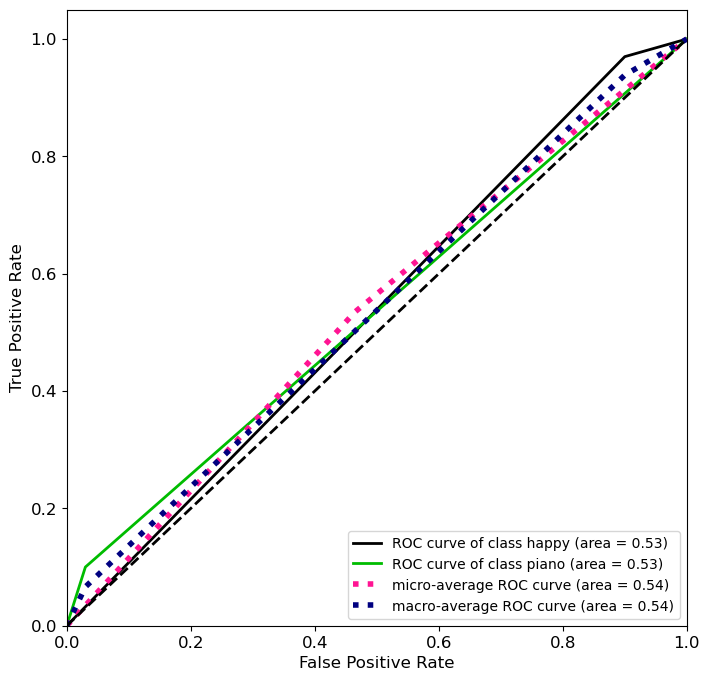

In [19]:
y_score = knn.predict_proba(X_test)

plot_roc(y_test, y_score, figsize=(8,8), title_fontsize=15, text_fontsize=12)
plt.title("")
plt.legend(loc='lower right' )  # bbox_to_anchor=(1, 0.5)
plt.show()

array([[97,  3],
       [90, 10]], dtype=int64)

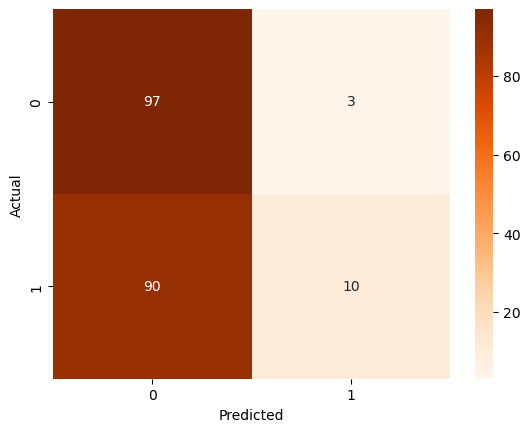

In [20]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap="Oranges")
plt.xlabel('Predicted')
plt.ylabel('Actual')
cm

### class PAA

In [21]:
X_paa

array([[-1.87585123,  1.50598159,  1.55320175, ...,  0.96700035,
         0.35610136, -2.10131551],
       [-2.47652117, -0.12386742, -0.02168557, ..., -0.51010433,
        -0.53456076, -2.3018653 ],
       [-1.44456759, -0.39691391, -1.40309965, ..., -0.83720962,
        -0.95806861, -2.15623091],
       ...,
       [-3.5237184 , -0.41890076, -0.07733713, ...,  1.73214091,
         2.55061997,  0.06713872],
       [-1.05736282, -0.39558174, -0.37957096, ..., -1.35737721,
        -1.34480787, -1.59833554],
       [-1.96334107, -0.07627904, -0.33675724, ..., -0.43969184,
        -0.51517952, -1.85892972]])

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X_paa, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 320), (200, 320), (800,), (200,))

euclidean

In [23]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'n_neighbors': [1, 3, 5, 10, 15, 30, 50],  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'p': [1, 2],  # Power parameter for the Minkowski metric (1: Manhattan distance, 2: Euclidean distance)
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid= param_grid, cv=5 )
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}

In [26]:
#cambiare nome modello

#alleno il modello con i migliori parametri:
knn = KNeighborsClassifier(p= 1, n_neighbors= 3, weights="distance", n_jobs=-1)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, digits =3))

Accuracy 0.625
F1-score [0.69387755 0.51612903]
              precision    recall  f1-score   support

       happy      0.586     0.850     0.694       100
       piano      0.727     0.400     0.516       100

    accuracy                          0.625       200
   macro avg      0.657     0.625     0.605       200
weighted avg      0.657     0.625     0.605       200



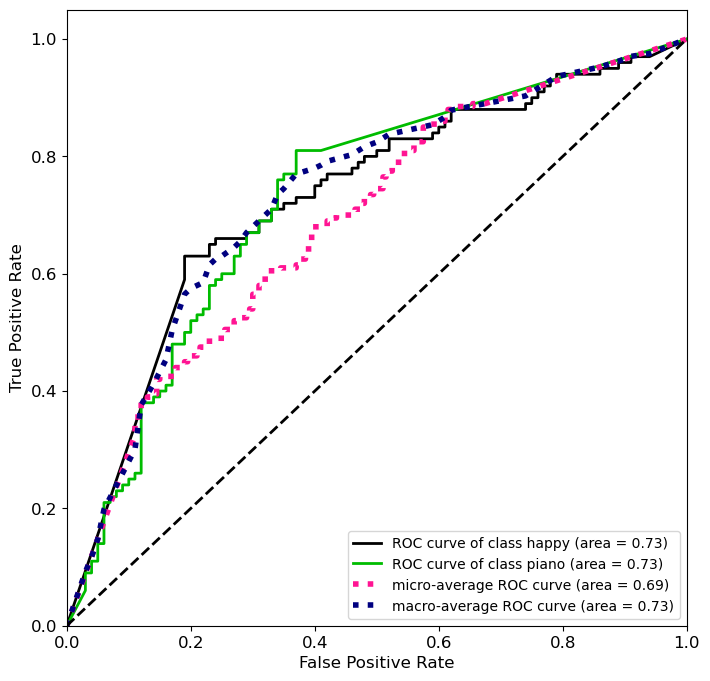

In [27]:
y_score = knn.predict_proba(X_test)

plot_roc(y_test, y_score, figsize=(8,8), title_fontsize=15, text_fontsize=12)
plt.title("")
plt.legend(loc='lower right' )  # bbox_to_anchor=(1, 0.5)
plt.show()

array([[85, 15],
       [60, 40]], dtype=int64)

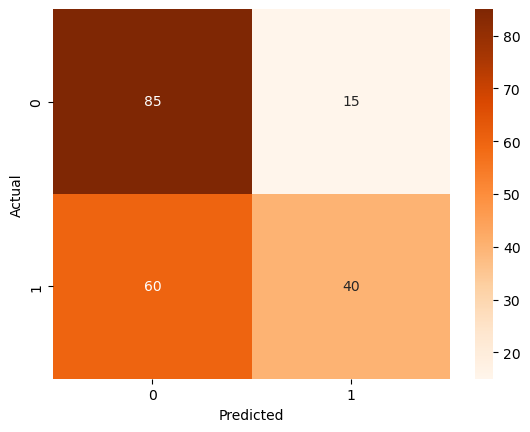

In [28]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap="Oranges")
plt.xlabel('Predicted')
plt.ylabel('Actual')
cm

DTW

In [29]:
from pyts.classification import KNeighborsClassifier #attenzione perchè si chiama uguale!!

In [30]:
%time
param_dist = {
    'n_neighbors': (1,3,5,10,15,30),  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    #'p': [1, 2],  # Power parameter for the Minkowski metric (1: Manhattan distance, 2: Euclidean distance)
   # 'metric': ['dtw_fast']  # Metrica per il DTW  'dtw', 'dtw_sakoechiba', 'dtw_itakura', 'dtw_fast
}

knn_dtw = KNeighborsClassifier(metric = 'dtw') 
random_search_dtw = RandomizedSearchCV(knn_dtw, param_distributions=param_dist, n_iter=5, cv=5, random_state=42)
random_search_dtw.fit(X_train, y_train)
random_search_dtw.best_params_

CPU times: total: 0 ns
Wall time: 0 ns


{'weights': 'distance', 'n_neighbors': 15}

In [31]:
#alleno il modello con i migliori parametri:
knn_dtw = KNeighborsClassifier(metric= "dtw", n_neighbors= 15, weights="distance", n_jobs=-1)
knn_dtw.fit(X_train, y_train)

y_pred = knn_dtw.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, digits =3))

Accuracy 0.845
F1-score [0.83060109 0.85714286]
              precision    recall  f1-score   support

       happy      0.916     0.760     0.831       100
       piano      0.795     0.930     0.857       100

    accuracy                          0.845       200
   macro avg      0.855     0.845     0.844       200
weighted avg      0.855     0.845     0.844       200



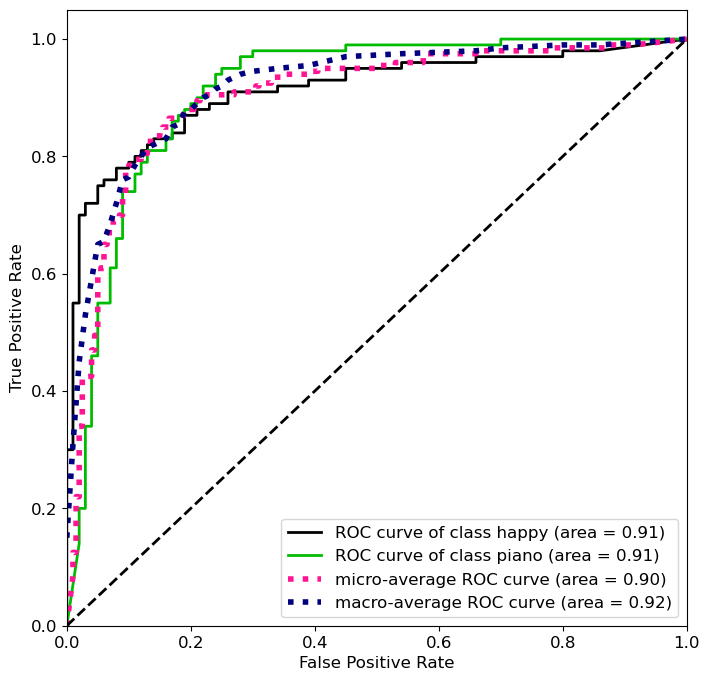

In [32]:
y_score_dtw = knn_dtw.predict_proba(X_test)
plot_roc(y_test, y_score_dtw, figsize=(8,8), title_fontsize=15, text_fontsize=12)
plt.title("")
plt.show()

array([[76, 24],
       [ 7, 93]], dtype=int64)

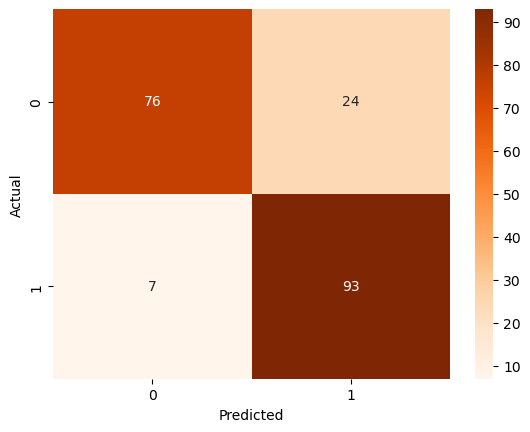

In [33]:
cm_dtw = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_dtw, annot=True, cmap="Oranges")
plt.xlabel('Predicted')
plt.ylabel('Actual')
cm_dtw

### class appr SAX

In [34]:
X_sax

array([[0, 1, 8, ..., 5, 5, 5],
       [0, 0, 3, ..., 6, 6, 7],
       [0, 1, 4, ..., 4, 4, 4],
       ...,
       [0, 0, 2, ..., 6, 5, 3],
       [1, 1, 3, ..., 7, 7, 6],
       [0, 0, 4, ..., 7, 6, 5]])

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X_sax, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 500), (200, 500), (800,), (200,))

euclidean/manhattan

In [36]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'n_neighbors': [1, 3, 5, 10, 15, 30, 50],  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'p': [1, 2],  # Power parameter for the Minkowski metric (1: Manhattan distance, 2: Euclidean distance)
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}

In [37]:
#alleno il modello con i migliori parametri:
knn = KNeighborsClassifier(p= 1, n_neighbors= 1, weights="uniform", n_jobs=-1)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, digits =3))

Accuracy 0.655
F1-score [0.68778281 0.61452514]
              precision    recall  f1-score   support

       happy      0.628     0.760     0.688       100
       piano      0.696     0.550     0.615       100

    accuracy                          0.655       200
   macro avg      0.662     0.655     0.651       200
weighted avg      0.662     0.655     0.651       200



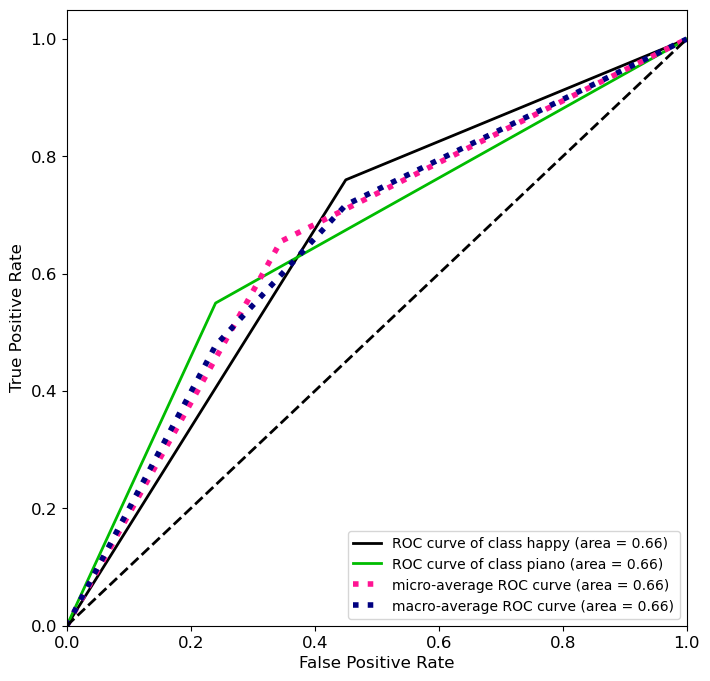

In [38]:
y_score = knn.predict_proba(X_test)

plot_roc(y_test, y_score, figsize=(8,8), title_fontsize=15, text_fontsize=12)
plt.title("")
plt.legend(loc='lower right' )  # bbox_to_anchor=(1, 0.5)
plt.show()

array([[76, 24],
       [45, 55]], dtype=int64)

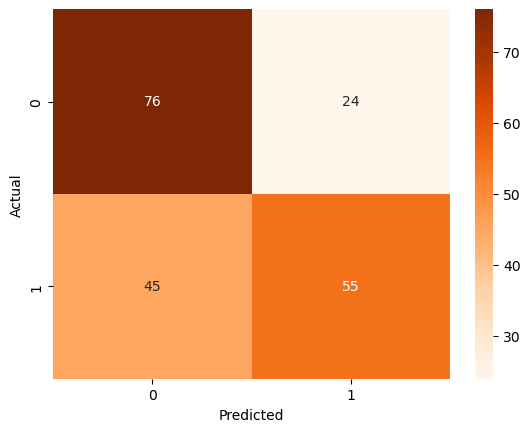

In [39]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap="Oranges")
plt.xlabel('Predicted')
plt.ylabel('Actual')
cm

DTW

In [40]:
from pyts.classification import KNeighborsClassifier #attenzione perchè si chiama uguale!!

In [41]:
%time
param_dist = {
    'n_neighbors': (1,3,5,10,15,30),  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    #'p': [1, 2],  # Power parameter for the Minkowski metric (1: Manhattan distance, 2: Euclidean distance)
   # 'metric': ['dtw_fast']  # Metrica per il DTW  'dtw', 'dtw_sakoechiba', 'dtw_itakura', 'dtw_fast
}

knn_dtw = KNeighborsClassifier(metric = 'dtw') 
random_search_dtw = RandomizedSearchCV(knn_dtw, param_distributions=param_dist, n_iter=5, cv=5, random_state=42)
random_search_dtw.fit(X_train, y_train)
random_search_dtw.best_params_

CPU times: total: 0 ns
Wall time: 0 ns


{'weights': 'distance', 'n_neighbors': 15}

In [42]:
#alleno il modello con i migliori parametri:
knn_dtw = KNeighborsClassifier(metric= "dtw", n_neighbors= 15, weights="distance", n_jobs=-1)
knn_dtw.fit(X_train, y_train)

y_pred = knn_dtw.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, digits =3))

Accuracy 0.83
F1-score [0.81914894 0.83962264]
              precision    recall  f1-score   support

       happy      0.875     0.770     0.819       100
       piano      0.795     0.890     0.840       100

    accuracy                          0.830       200
   macro avg      0.835     0.830     0.829       200
weighted avg      0.835     0.830     0.829       200



In [43]:
y_score_dtw = knn_dtw.predict_proba(X_test)
plot_roc(y_test, y_score_dtw, figsize=(8,8), title_fontsize=15, text_fontsize=15)
plt.title("")
plt.show()

In [ ]:
cm_dtw = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_dtw, annot=True, cmap="Oranges")
plt.xlabel('Predicted')
plt.ylabel('Actual')
cm_dtw